# Import libraries

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

# Hyperparameters

In [14]:
data_size = 5000
max_epoch = 10000
learning_rate = 1e-4

# Generate data

/tmp/ipykernel_46208/2024700253.py:7: RuntimeWarning: invalid value encountered in log
  y = np.log(x) * np.sin(20 * x) + y_noise


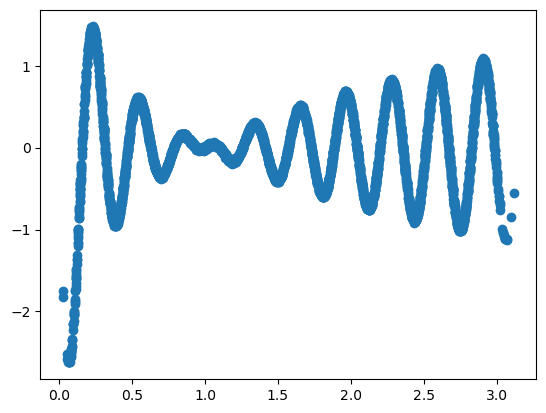

In [15]:
x_noise = np.random.normal(scale=0.05, size=data_size)
y_noise = np.random.normal(scale=0.01, size=data_size)

x_no_noise = np.linspace(0.1, 3, num=data_size, dtype=np.float64)
y_no_noise = np.log(x_no_noise) * np.sin(20 * x_no_noise)
x = x_no_noise + x_noise
y = np.log(x) * np.sin(20 * x) + y_noise

x_no_noise = torch.from_numpy(np.reshape(x_no_noise, (data_size, 1))).float()
y_no_noise = torch.from_numpy(np.reshape(y_no_noise, (data_size, 1))).float()
x = torch.from_numpy(np.reshape(x, (data_size, 1))).float()
y = torch.from_numpy(np.reshape(y, (data_size, 1))).float()

plt.scatter(x, y)

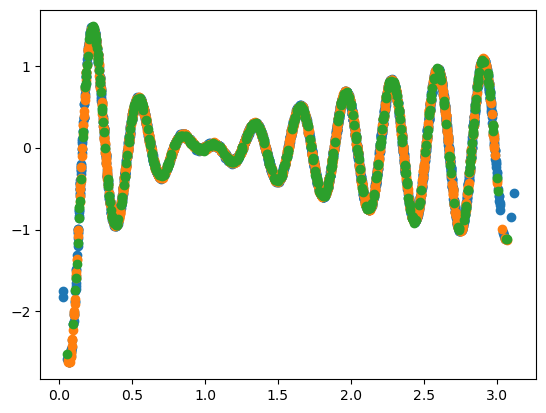

In [16]:
x_train_valid, x_test, y_train_valid, y_test = train_test_split(
    x, y, test_size=0.1, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid,
                                                      y_train_valid,
                                                      test_size=0.33,
                                                      random_state=42)

plt.scatter(x_train, y_train)
plt.scatter(x_valid, y_valid)
plt.scatter(x_test, y_test)

# Create basic net

In [17]:
class Basic_model(nn.Module):
    def __init__(self):
        super(Basic_model, self).__init__()
        self.hidden = nn.Linear(1, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(128, 128)
        self.hidden_3 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)

    def forward(self, x):
        hidden = torch.tanh(self.hidden(x))
        hidden = torch.tanh(self.hidden_1(hidden))
        hidden = torch.tanh(self.hidden_2(hidden))
        hidden = torch.relu(self.hidden_3(hidden))
        output = self.output(hidden)
        return output, hidden

In [18]:
model = Basic_model()
model

Basic_model(
  (hidden): Linear(in_features=1, out_features=128, bias=True)
  (hidden_1): Linear(in_features=128, out_features=128, bias=True)
  (hidden_2): Linear(in_features=128, out_features=128, bias=True)
  (hidden_3): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)

In [19]:
# init weights
def init_weights(model) -> None:
    if isinstance(model, nn.Linear):
        torch.nn.init.xavier_uniform_(model.weight)
        model.bias.data.fill_(0.01)


model.apply(init_weights)

if torch.cuda.is_available():
    model = model.cuda()
    
if torch.cuda.is_available():
    x_no_noise, y_no_noise, x, y = x_no_noise.cuda(), y_no_noise.cuda(), x.cuda(), y.cuda()

In [20]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
# prediction of model before training
y_before, hidden_out_before = model(x_no_noise)

# Train loop

In [30]:
losses_train = []
losses_valid = []
losses_test = []  # I known that this is ridiculous
weights_hidden = []
weights_out = []

for epoch in range(max_epoch):
    # weights_hidden.append(np.reshape(model.hidden.weight.detach().numpy().copy(), (256)))
    # weights_out.append(np.reshape(model.output.weight.detach().numpy().copy(), (256)))

    train_loss = 0.0
    for data, target in zip(x_train, y_train):
        
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        prediction, _ = model(data)
        loss = loss_function(prediction, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    valid_loss = 0.0
    for data, target in zip(x_valid, y_valid):
        
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        
        prediction, _ = model(data)
        loss = loss_function(prediction, target)
        valid_loss += loss.item()

    test_loss = 0.0
    for data, target in zip(x_test, y_test):
        
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        
        prediction, _ = model(data)
        loss = loss_function(prediction, target)
        test_loss += loss.item()

    print(
        f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(x_train)} \t\t Validation Loss: {valid_loss / len(x_valid)}'
    )
    losses_train.append(train_loss / len(x_train))
    losses_valid.append(valid_loss / len(x_valid))
    losses_test.append(test_loss / len(x_test))

Epoch 1 		 Training Loss: 0.05265542880771693 		 Validation Loss: 0.05166817864659099
Epoch 2 		 Training Loss: 0.05255690708692036 		 Validation Loss: 0.05157512534967634
Epoch 3 		 Training Loss: 0.052466981579344915 		 Validation Loss: 0.051467703765507966
Epoch 4 		 Training Loss: 0.052376128509773946 		 Validation Loss: 0.051358966515659896
Epoch 5 		 Training Loss: 0.05228178911560797 		 Validation Loss: 0.0512561055635536
Epoch 6 		 Training Loss: 0.05219339022419783 		 Validation Loss: 0.051178083957258556
Epoch 7 		 Training Loss: 0.05210696391334039 		 Validation Loss: 0.05106700336871092
Epoch 8 		 Training Loss: 0.05201291032724837 		 Validation Loss: 0.05097779357915386
Epoch 9 		 Training Loss: 0.05192556834060932 		 Validation Loss: 0.050874522988424827
Epoch 10 		 Training Loss: 0.05184107274082622 		 Validation Loss: 0.05077345645203043
Epoch 11 		 Training Loss: 0.051749037929059535 		 Validation Loss: 0.050683255301559024
Epoch 12 		 Training Loss: 0.0516636961070187

KeyboardInterrupt: 

In [40]:
torch.save(model.state_dict(), "model_state.pt")

# Check accuracy

In [31]:
def max_abs_error(prediction: torch.Tensor,
                  target: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.absolute(prediction - target))


def mean_square_error(prediction: torch.Tensor,
                      target: torch.Tensor) -> torch.Tensor:
    return torch.mean(torch.square(prediction - target))


def rmse(prediction: torch.Tensor,
         target: torch.Tensor) -> torch.Tensor:
    return torch.sqrt(torch.sum(torch.square(prediction - target))/len(target))

In [32]:
y_predict_train, _ = model(x_train)
y_predict_valid, _ = model(x_valid)
y_predict_test, _ = model(x_test)


In [33]:
print(max_abs_error(y_predict_train, y_train))
print(max_abs_error(y_predict_valid, y_valid))
print(max_abs_error(y_predict_test, y_test))

tensor(1.0603, grad_fn=<MaxBackward1>)
tensor(0.6810, grad_fn=<MaxBackward1>)
tensor(nan, grad_fn=<MaxBackward1>)


In [34]:
print(mean_square_error(y_predict_train, y_train))
print(mean_square_error(y_predict_valid, y_valid))
print(mean_square_error(y_predict_test, y_test))

tensor(0.0347, grad_fn=<MeanBackward0>)
tensor(0.0334, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)


In [35]:
print(rmse(y_predict_train, y_train))
print(rmse(y_predict_valid, y_valid))
print(rmse(y_predict_test, y_test))

tensor(0.1864, grad_fn=<SqrtBackward0>)
tensor(0.1829, grad_fn=<SqrtBackward0>)
tensor(nan, grad_fn=<SqrtBackward0>)


# Check prediction

In [36]:
y_after, hidden_layer_after = model(x_no_noise)

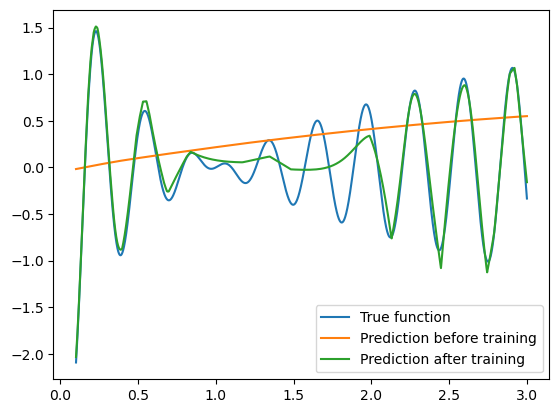

In [37]:
plt.plot(x_no_noise.cpu(), y_no_noise.cpu(), label='True function')
plt.plot(x_no_noise.cpu(),
         y_before.cpu().detach().numpy(),
         label='Prediction before training')
plt.plot(x_no_noise.cpu(),
         y_after.cpu().detach().numpy(),
         label='Prediction after training')

plt.legend()
plt.show()

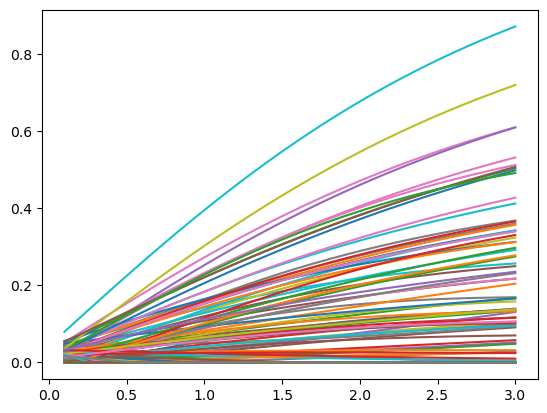

In [38]:
plt.plot(x_no_noise, hidden_out_before.detach().numpy())

plt.show()

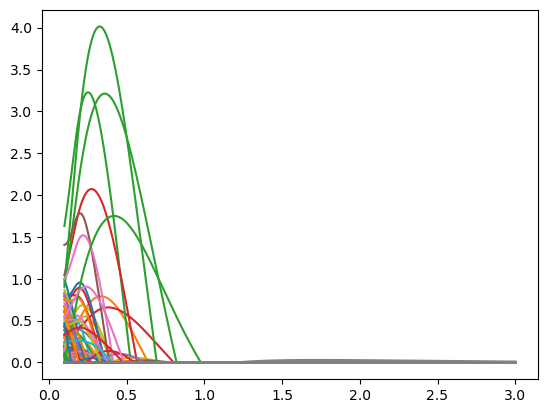

In [ ]:
plt.plot(x_no_noise, hidden_layer_after.detach().numpy())

plt.show()

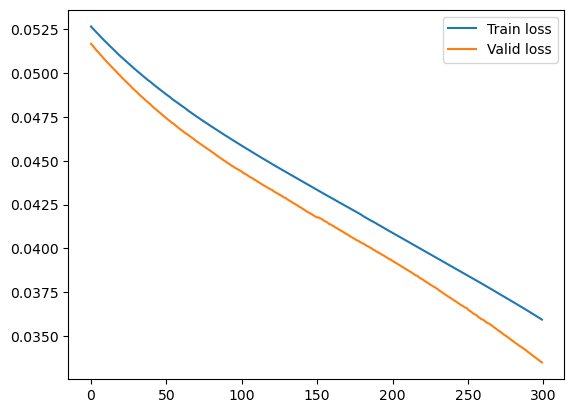

In [39]:
epoch = [i for i in range(len(losses_train))]
plt.plot(epoch, losses_train, label='Train loss')
plt.plot(epoch, losses_valid, label='Valid loss')
# plt.plot(epoch, losses_test, label='Test loss')

plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (700,) and (0,)

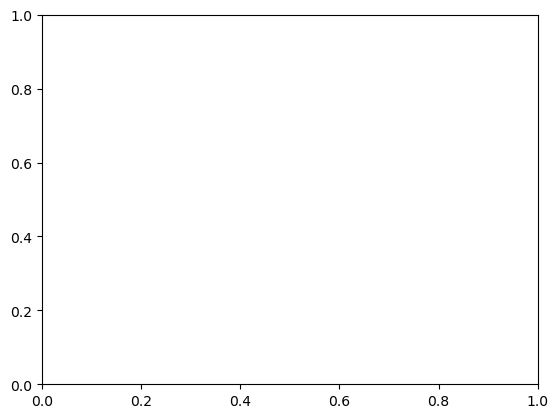

In [ ]:
plt.plot(epoch, weights_hidden)

plt.show()

In [ ]:
plt.plot(epoch, weights_out)

plt.show()